# Load packages

In [84]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display, clear_output
from PIL import Image
import time
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import pandas as pd
import scipy.signal as signal

# Load and watch video to get crop and particle radius

In [72]:
# Open the video file
video_path = "Videos/trappedparticle06.mp4"

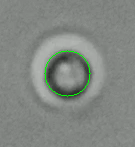

KeyboardInterrupt: 

In [44]:
# Adjust these values (slowly) to get the correct crop
# You really want to just have the bead in the frame and not much else
# You also want it to be relatively centered (for the radius estimation below)
crop = np.s_[850:-925, 1300:-1125]

# The radius of the bead in pixels
# Adjust this value (slowly) to get an approximation of the radius (the exact value is not important)
# This will just be used to establish a rough estimate for the tracking algorithm later
radius = 23

#######################################################
### You shouldn't need to touch anything below here ###
#######################################################

# Open the video file
cap = cv2.VideoCapture(video_path)

if not cap.isOpened():
    raise Exception("Error: Unable to open video file.")

# Get the video framerate
fps = cap.get(cv2.CAP_PROP_FPS)
frame_delay = 1 / fps  # Delay between frames in seconds

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Crop the image
    frame = frame[crop]

    # Add a circle to the image
    cv2.circle(frame, (frame.shape[1] // 2, frame.shape[0] // 2), radius, (0, 255, 0), 1)
    
    # Convert BGR to RGB for displaying in Jupyter
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    img = Image.fromarray(frame_rgb)
    
    # Display the frame
    display(img)
    
    # Pause for the actual frame delay
    time.sleep(frame_delay)
    clear_output(wait=True)

cap.release()


# Track particle

In [55]:
# File path to save tracking data
tracking_path = "trappedparticle06.csv"

In [70]:
#######################################################
### You shouldn't need to touch anything below here ###
#######################################################

cap = cv2.VideoCapture(video_path)

if not cap.isOpened():
    raise Exception("Error: Unable to open video file.")

# Store tracking results
tracking_data = []

frame_index = 0
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break  # End of video

    # Crop the image to focus on the region of interest
    frame = frame[crop]

    # Convert the frame to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (9, 9), 2)

    # Detect circles using Hough Transform
    circles = cv2.HoughCircles(
        blurred,
        cv2.HOUGH_GRADIENT,
        dp=1.2,  # Inverse ratio of resolution
        minDist=50,  # Minimum distance between circle centers
        param1=50,  # Higher threshold for Canny edge detector
        param2=30,  # Accumulator threshold for circle detection
        minRadius=radius - 2,
        maxRadius=radius + 2
    )

    # If a circle is detected, store its coordinates
    if circles is not None:
        circles = np.round(circles[0, :]).astype("int")
        x, y, r = circles[0]  # Take the first detected circle (most prominent)
        tracking_data.append({"frame": frame_index, "x": x, "y": y, "radius": r})

    frame_index += 1

# Release the video capture object
cap.release()

# Save tracking data to a CSV
tracking_df = pd.DataFrame(tracking_data)
tracking_df.to_csv(tracking_path, index=False)

print("Tracking complete. Data saved to '{}'".format(tracking_path))

Tracking complete. Data saved to 'trappedparticle06.csv'


### View the tracking results with and without the underlying video (for a sanity check)

"GIF saved as 'tracking_result.gif'."

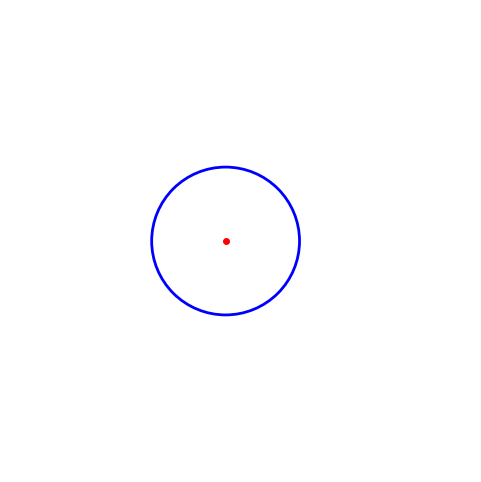

In [ ]:
#######################################################
### You shouldn't need to touch anything below here ###
#######################################################

# Tracking data
tracking_df = pd.read_csv(tracking_path)

# Set up the figure
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_xlim(0, 150)
ax.set_ylim(0, 150)
ax.set_aspect('equal')
ax.axis("off")  # Clean white background

# Initialize circle and center dot
circle = plt.Circle((0, 0), 1, edgecolor='blue', facecolor='none', lw=2)
center_dot, = ax.plot([], [], 'ro', markersize=4)

# Add circle to the plot
ax.add_artist(circle)

# Update function for the animation
def update(frame):
    row = tracking_df.iloc[frame]
    x, y, r = row["x"], row["y"], row["radius"]
    circle.center = (x, y)
    circle.set_radius(r)
    center_dot.set_data([x], [y])  # Set as lists to avoid errors
    return circle, center_dot

# Create the animation
ani = FuncAnimation(fig, update, frames=len(tracking_df))

# Save as a GIF
ani.save("tracking_result.gif", fps=14, writer="pillow")
display("GIF saved as 'tracking_result_no_video.gif'.")


In [ ]:
overlay_output_path = "tracking_overlay_video.mp4"
white_background_output_path = "tracking_white_background_video.mp4"

#######################################################
### You shouldn't need to touch anything below here ###
#######################################################

# Load tracking data
tracking_df = pd.read_csv(tracking_path)

# Load the input video
cap = cv2.VideoCapture(video_path)

if not cap.isOpened():
    raise Exception("Error: Unable to open video file.")

# Get video properties
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))

# Apply the crop to the frame size
cropped_frame = cap.read()[1][crop]  # Get a cropped frame to determine the new dimensions
cropped_width = cropped_frame.shape[1]
cropped_height = cropped_frame.shape[0]

# Set up the video writers for both output videos with cropped dimensions
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec for mp4 video

overlay_out = cv2.VideoWriter(overlay_output_path, fourcc, fps, (cropped_width, cropped_height))
white_background_out = cv2.VideoWriter(white_background_output_path, fourcc, fps, (cropped_width, cropped_height))

# Iterate through each frame of the video
frame_index = 0
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break  # End of video

    # Crop the frame using the np.s_ indexing
    cropped_frame = frame[crop]

    # Get tracking data for the current frame
    if frame_index < len(tracking_df):
        row = tracking_df.iloc[frame_index]
        x, y, r = row["x"], row["y"], row["radius"]

        # For overlay video: Draw the circle (outline) and center dot
        overlay_frame = cropped_frame.copy()
        cv2.circle(overlay_frame, (x, y), r, (0, 255, 0), 2)  # Circle outline in green
        cv2.circle(overlay_frame, (x, y), 2, (0, 0, 255), 1)  # Center dot in red

        # For white background video: Create a white frame and draw the circle (outline) and center dot
        white_frame = np.ones_like(cropped_frame) * 255  # White background
        cv2.circle(white_frame, (x, y), r, (0, 255, 0), 2)  # Circle outline in green
        cv2.circle(white_frame, (x, y), 2, (0, 0, 255), 1)  # Center dot in red

        # Write both frames to their respective output videos
        overlay_out.write(overlay_frame)
        white_background_out.write(white_frame)

    frame_index += 1

# Release the video capture and writer objects
cap.release()
overlay_out.release()
white_background_out.release()

# Close any OpenCV windows
cv2.destroyAllWindows()

print(f"Tracking overlay video saved as '{overlay_output_path}'.")
print(f"Tracking white background video saved as '{white_background_output_path}'.")

Tracking overlay video saved as 'tracking_overlay_video.mp4'.
Tracking white background video saved as 'tracking_white_background_video.mp4'.


# Calculate PSD of horizontal/vertical movement

In [ ]:
# File path to read tracking data
tracking_path = "trappedparticle06.csv"

# Path to the video file
video_path = "Videos/trappedparticle06.mp4"

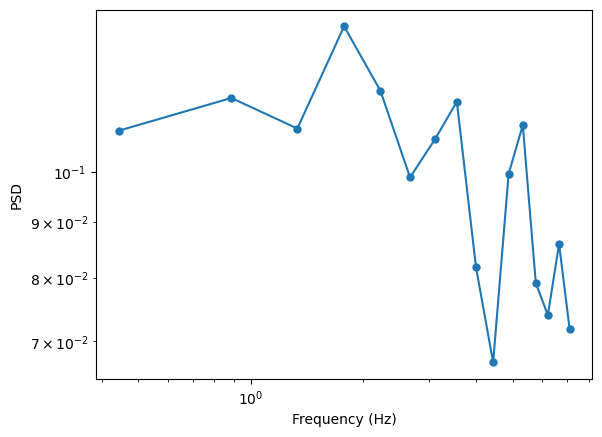

In [89]:
tracking_data = pd.read_csv(tracking_path)
x = tracking_data['x'] # Extract the signal
x = x - x.mean() # De-mean the signal

# Open the video file
cap = cv2.VideoCapture(video_path)

if not cap.isOpened():
    raise Exception("Error: Unable to open video file.")

# Get the video framerate
fps = cap.get(cv2.CAP_PROP_FPS)
cap.release()

dt = 1 / fps  # Delay between frames in seconds
total_timesteps = len(tracking_data) # Get the total number of time steps

# Compute PSD using scipy.signal.welch for better performance
welch = signal.welch(x, fs=1/dt, nperseg=2**5, scaling='density')
freqs = welch[0]
psd = welch[1]

psds = pd.DataFrame({'Frequency': freqs, 'PSD': psd})

# We only graph low frequencies, since higher ones are noise
mask = psds['Frequency'] > 0 # Ignore the zero frequency
mask &= psds['Frequency'] < 1000
# plt.plot(psds['Frequency'][mask], psds['PSD'][mask])
# We use a scatter plot with a connecting line
plt.plot(psds['Frequency'][mask], psds['PSD'][mask] , 'o-', markersize=5)
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD')
plt.xscale('log')
plt.yscale('log')